In [8]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.problems import get_problem
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from scipy.stats import cauchy
from scipy.spatial.distance import cdist
from tabulate import tabulate
import seaborn as sns

In [9]:
class ProblemWrapper:
    def __init__(self, p_prob):
        self.n_var = p_prob.n_var
        self.n_obj = p_prob.n_obj
        self.xl = p_prob.xl
        self.xu = p_prob.xu
        self.p_prob = p_prob

    def evaluate(self, x):
        return self.p_prob.evaluate(x)

class Individual:
    __slots__ = ['X', 'F', 'rank', 'crowding_dist', 'domination_count', 
                 'dominated_set', 'creation_mode', 'used_F', 'used_CR']

    def __init__(self):
        self.X = None
        self.F = None
        self.rank = None
        self.crowding_dist = 0.0
        self.domination_count = 0
        self.dominated_set = []
        self.creation_mode = 'init'
        self.used_F = 0.5
        self.used_CR = 0.5

class NSGA2_Improved_Smart:
    def __init__(self, problem, pop_size=100, n_gen=100):
        # Cấu hình bài toán
        self.problem = problem
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.n_var = problem.n_var
        self.n_obj = problem.n_obj
        self.xl = problem.xl
        self.xu = problem.xu

        # Tham số thích nghi (Adaptive Parameters)
        self.mean_F = 0.5
        self.mean_CR = 0.5
        self.prob_de = 0.5
        
        # Tham số thuật toán
        self.T_neighbors = max(5, int(self.pop_size * 0.15))
        self.pc = 0.9
        self.pm = 1.0 / self.n_var
        self.eta_c = 20
        self.eta_m = 20
        
        # Lưu trữ
        self.population = []
        self.history = []

    def initialize_population_obl(self):
        # 1. Tạo ngẫu nhiên & Tạo đối lập
        X_rand = self.xl + np.random.rand(self.pop_size, self.n_var) * (self.xu - self.xl)
        X_obl = self.xl + self.xu - X_rand
        
        # 2. Gộp và đánh giá toàn bộ
        X_all = np.vstack([X_rand, X_obl])
        X_all = np.clip(X_all, self.xl, self.xu)
        F_all = self.problem.evaluate(X_all)
        
        full_pop = []
        for i in range(len(X_all)):
            ind = Individual()
            ind.X = X_all[i]
            ind.F = F_all[i] if F_all.ndim > 1 else F_all
            full_pop.append(ind)
            
        # 3. Lọc lấy N cá thể tốt nhất qua Non-dominated sort
        fronts = self.fast_non_dominated_sort(full_pop)
        new_pop = []
        for front in fronts:
            self.calculate_crowding_distance(front)
            if len(new_pop) + len(front) <= self.pop_size:
                new_pop.extend(front)
            else:
                front.sort(key=lambda x: x.crowding_dist, reverse=True)
                new_pop.extend(front[:self.pop_size - len(new_pop)])
                break
                
        return new_pop

    def check_duplicates(self, pop, epsilon=1e-5):
        #Loại bỏ các cá thể trùng nhau về không gian mục tiêu.
        if not pop: return pop
        
        F_matrix = np.array([ind.F for ind in pop])
        n = len(pop)
        
        # Tính ma trận khoảng cách
        dists = cdist(F_matrix, F_matrix, metric='euclidean')
        is_duplicate = np.zeros(n, dtype=bool)
        
        for i in range(n):
            if is_duplicate[i]: continue
            # Tìm các cá thể phía sau (j > i) quá gần cá thể i
            duplicates = np.where(dists[i, i+1:] < epsilon)[0] + (i + 1)
            is_duplicate[duplicates] = True
            
        return [pop[i] for i in range(n) if not is_duplicate[i]]

    def fast_non_dominated_sort(self, population):
        F = np.array([ind.F for ind in population])
        n = len(population)
        
        # Tính toán quan hệ trội (Vector hóa)
        less_equal = (F[:, None] <= F[None, :]).all(axis=2)
        less = (F[:, None] < F[None, :]).any(axis=2)
        dominates_mat = less_equal & less 

        domination_counts = dominates_mat.sum(axis=0)
        # Pre-compute danh sách bị trội dưới dạng index
        dominated_sets_idx = [np.where(dominates_mat[i])[0].tolist() for i in range(n)]

        fronts = []
        # Tìm Front 1
        current_front_indices = np.where(domination_counts == 0)[0].tolist()
        
        if not current_front_indices: return []

        # Gán rank và lưu object
        front0_objs = []
        for idx in current_front_indices:
            population[idx].rank = 1
            front0_objs.append(population[idx])
        fronts.append(front0_objs)

        # Lan truyền rank (Peeling)
        i = 0
        while current_front_indices:
            next_front_indices = []
            for p_idx in current_front_indices:
                for q_idx in dominated_sets_idx[p_idx]:
                    domination_counts[q_idx] -= 1
                    if domination_counts[q_idx] == 0:
                        population[q_idx].rank = i + 2
                        next_front_indices.append(q_idx)
            
            i += 1
            if next_front_indices:
                current_front_indices = next_front_indices
                fronts.append([population[idx] for idx in next_front_indices])
            else:
                break
                
        return fronts

    def calculate_crowding_distance(self, front):
        l = len(front)
        if l == 0: return
        
        for ind in front: 
            ind.crowding_dist = 0.0

        for m in range(self.n_obj):
            # Sắp xếp theo từng mục tiêu
            front.sort(key=lambda x: x.F[m])
            
            # Gán vô cực cho biên
            front[0].crowding_dist = float('inf')
            front[-1].crowding_dist = float('inf')
            
            f_min, f_max = front[0].F[m], front[-1].F[m]
            if f_max == f_min: continue
            
            norm = f_max - f_min
            for i in range(1, l - 1):
                if front[i].crowding_dist != float('inf'):
                    front[i].crowding_dist += (front[i+1].F[m] - front[i-1].F[m]) / norm
    def generate_obl_offspring(self, population, jump_rate=0.1):
        obl_pop = []
        # Tính toán min/max động của quần thể hiện tại (thu hẹp không gian tìm kiếm)
        X_mat = np.array([ind.X for ind in population])
        curr_min = np.min(X_mat, axis=0)
        curr_max = np.max(X_mat, axis=0)

        for ind in population:
            if np.random.rand() < jump_rate:
                ind_obl = Individual()
                # Lai ghép giữa OBL toàn cục và OBL cục bộ
                if np.random.rand() < 0.5:
                     X_obl = self.xl + self.xu - ind.X
                else:
                     X_obl = curr_min + curr_max - ind.X
                
                ind_obl.X = np.clip(X_obl, self.xl, self.xu)
                ind_obl.creation_mode = 'obl'
                obl_pop.append(ind_obl)
        
        return obl_pop
    
    def get_neighborhood_indices(self, population):
        #Tìm K láng giềng gần nhất trong không gian mục tiêu.
        F_matrix = np.array([ind.F for ind in population])
        
        # Chuẩn hóa để tính khoảng cách công bằng
        f_min, f_max = np.min(F_matrix, axis=0), np.max(F_matrix, axis=0)
        denom = f_max - f_min
        denom[denom == 0] = 1e-10
        F_norm = (F_matrix - f_min) / denom

        dists = cdist(F_norm, F_norm)
        # argpartition nhanh hơn sort khi chỉ cần lấy top K
        return np.argpartition(dists, kth=self.T_neighbors, axis=1)[:, :self.T_neighbors]

    def smart_de_mutation(self, target_idx, population, neighbors_indices):
        target = population[target_idx]
        use_global_de = np.random.rand() < 0.3 # 30% cơ hội dùng Global DE

        if use_global_de:
            # DE/rand/1: Chọn ngẫu nhiên hoàn toàn từ quần thể
            r1, r2, r3 = random.sample(population, 3)
            
            F_gen = 0.8 + 0.2 * np.random.rand() # F lớn [0.8, 1.0]
            CR_gen = 0.2 # CR nhỏ để thay đổi ít chiều
            
            v = r1.X + F_gen * (r2.X - r3.X)
        else:
            neighbors = [population[i] for i in neighbors_indices[target_idx]]
            neighbors.sort(key=lambda x: (x.rank, -x.crowding_dist))
            top_k = max(1, int(len(neighbors) * 0.2))
            x_pbest = random.choice(neighbors[:top_k])
            
            potential = [p for p in neighbors if p != target]
            pool = potential if len(potential) >= 2 else population
            r1, r2 = random.sample(pool, 2)

            F_gen = np.clip(cauchy.rvs(loc=self.mean_F, scale=0.1), 0.1, 1.0)
            CR_gen = np.clip(np.random.normal(self.mean_CR, 0.1), 0.0, 1.0)
            
            diff_best = x_pbest.X - target.X
            diff_rand = r1.X - r2.X
            v = target.X + F_gen * diff_best + F_gen * diff_rand

        # Crossover nhị phân
        mask = np.random.rand(self.n_var) <= CR_gen
        mask[np.random.randint(self.n_var)] = True 
        u = np.where(mask, v, target.X)
        
        child = Individual()
        child.X = np.clip(u, self.xl, self.xu)
        child.creation_mode = 'de_global' if use_global_de else 'de_local'
        child.used_F = F_gen
        child.used_CR = CR_gen
        return child
    
    def sbx_crossover_mutation(self, p1, p2):
        #Lai ghép SBX và Đột biến đa thức (Polynomial Mutation).
        c = Individual()
        c.X = p1.X.copy()
        
        # --- SBX Crossover ---
        if np.random.rand() <= self.pc:
            rand_mask = np.random.rand(self.n_var)
            swap_mask = rand_mask <= 0.5
            diff_mask = np.abs(p1.X - p2.X) > 1e-14
            
            idx = swap_mask & diff_mask
            
            if np.any(idx):
                y1 = np.minimum(p1.X[idx], p2.X[idx])
                y2 = np.maximum(p1.X[idx], p2.X[idx])
                yl, yu = self.xl[idx], self.xu[idx]
                
                rand = np.random.rand(np.sum(idx))
                beta = 1.0 + (2.0 * (y1 - yl) / (y2 - y1))
                alpha = 2.0 - np.power(beta, -(self.eta_c + 1.0))
                
                betaq = np.empty_like(rand)
                mask_beta = rand <= (1.0 / alpha)
                
                # Tính betaq theo 2 trường hợp
                if np.any(mask_beta):
                    betaq[mask_beta] = np.power(rand[mask_beta] * alpha[mask_beta], 1.0/(self.eta_c+1.0))
                if np.any(~mask_beta):
                    betaq[~mask_beta] = np.power(1.0/(2.0 - rand[~mask_beta]*alpha[~mask_beta]), 1.0/(self.eta_c+1.0))
                
                c.X[idx] = 0.5 * ((y1 + y2) - betaq * (y2 - y1))
                c.X[idx] = np.clip(c.X[idx], yl, yu)

        # --- Polynomial Mutation ---
        mut_mask = np.random.rand(self.n_var) <= self.pm
        if np.any(mut_mask):
            y = c.X[mut_mask]
            yl, yu = self.xl[mut_mask], self.xu[mut_mask]
            
            delta1 = (y - yl) / (yu - yl)
            delta2 = (yu - y) / (yu - yl)
            
            rand = np.random.rand(len(y))
            mut_pow = 1.0 / (self.eta_m + 1.0)
            deltaq = np.empty_like(y)
            
            mask_low = rand <= 0.5
            if np.any(mask_low):
                val = 2.0 * rand[mask_low] + (1.0 - 2.0 * rand[mask_low]) * np.power(1.0 - delta1[mask_low], self.eta_m + 1.0)
                deltaq[mask_low] = np.power(val, mut_pow) - 1.0
            
            mask_high = ~mask_low
            if np.any(mask_high):
                val = 2.0 * (1.0 - rand[mask_high]) + 2.0 * (rand[mask_high] - 0.5) * np.power(1.0 - delta2[mask_high], self.eta_m + 1.0)
                deltaq[mask_high] = 1.0 - np.power(val, mut_pow)
                
            c.X[mut_mask] = np.clip(y + deltaq * (yu - yl), yl, yu)

        c.creation_mode = 'sbx'
        return c

    def update_adaptive_mechanisms(self, offspring):
        #Cập nhật xác suất chọn DE/SBX và tham số F, CR dựa trên thành công.
        success_F, success_CR = [], []
        count_de, count_sbx = 0, 0
        
        for ind in offspring:
            if ind.creation_mode == 'de':
                count_de += 1
                # Nếu con DE lên top rank 1 -> Ghi nhận thành công
                if ind.rank == 1:
                    success_F.append(ind.used_F)
                    success_CR.append(ind.used_CR)
            elif ind.creation_mode == 'sbx':
                count_sbx += 1

        # Cân bằng tỷ lệ chọn DE
        total = count_de + count_sbx
        if total > 0:
            self.prob_de = np.clip(0.9 * self.prob_de + 0.1 * (count_de / total), 0.2, 0.8)

        # Cân bằng F và CR (Lehmer mean)
        if success_F:
            arr_F = np.array(success_F)
            mean_pow2 = np.mean(arr_F**2)
            mean_pow1 = np.mean(arr_F)
            new_mean_F = mean_pow2 / mean_pow1 if mean_pow1 > 0 else self.mean_F
            
            self.mean_F = 0.9 * self.mean_F + 0.1 * new_mean_F
            self.mean_CR = 0.9 * self.mean_CR + 0.1 * np.mean(success_CR)

    def tournament_selection(self, pop):
        #Binary Tournament: Chọn người rank thấp hơn hoặc crowding distance lớn hơn.
        p1, p2 = random.sample(pop, 2)
        if p1.rank != p2.rank:
            return p1 if p1.rank < p2.rank else p2
        return p1 if p1.crowding_dist > p2.crowding_dist else p2

    def run(self, initial_X=None):
        # 1. Khởi tạo
        self.population = self.initialize_population_obl() if initial_X is None else self.initialize_population(initial_X)

        fronts = self.fast_non_dominated_sort(self.population)
        for front in fronts: self.calculate_crowding_distance(front)

        last_best_ideal = None
        stagnation_counter = 0
        restart_patience = self.n_gen // 4

        # --- VÒNG LẶP TIẾN HÓA CHÍNH ---
        for gen in range(self.n_gen):
            current_F = np.array([ind.F for ind in self.population])
            current_ideal = np.min(current_F, axis=0)
            
            if last_best_ideal is None:
                last_best_ideal = current_ideal
            else:
                dist = np.linalg.norm(current_ideal - last_best_ideal)
                if dist < 1e-4: stagnation_counter += 1
                else: stagnation_counter = 0; last_best_ideal = current_ideal

            # Cơ chế Khởi động lại (Restart) nếu bị kẹt
            if stagnation_counter >= restart_patience:
                n_keep = int(self.pop_size * 0.3) # Giữ 30% tốt nhất
                pop_keep = self.population[:n_keep]
                
                # Random 70% còn lại
                n_new = self.pop_size - n_keep
                X_new = self.xl + np.random.rand(n_new, self.n_var) * (self.xu - self.xl)
                F_new = self.problem.evaluate(X_new)
                
                pop_new = []
                for k in range(n_new):
                    ind = Individual()
                    ind.X = X_new[k]
                    ind.F = F_new[k] if F_new.ndim > 1 else F_new
                    pop_new.append(ind)
                
                self.population = pop_keep + pop_new
                
                # Re-sort và reset tham số
                fronts = self.fast_non_dominated_sort(self.population)
                for front in fronts: self.calculate_crowding_distance(front)
                
                stagnation_counter = 0
                self.mean_F = 0.5; self.mean_CR = 0.5
                continue 

            neighbors_indices = self.get_neighborhood_indices(self.population)
            offspring = []
            offspring_X_mat = np.empty((self.pop_size, self.n_var)) 
            for i in range(self.pop_size):
                if np.random.rand() < self.prob_de:
                    child = self.smart_de_mutation(i, self.population, neighbors_indices)
                else:
                    p1 = self.tournament_selection(self.population)
                    p2 = self.tournament_selection(self.population)
                    child = self.sbx_crossover_mutation(p1, p2)
                
                offspring.append(child)
                offspring_X_mat[i] = child.X
            if gen % 10 == 0: 
                obl_offspring = self.generate_obl_offspring(self.population, jump_rate=0.2) # 20% thử đảo ngược
                offspring.extend(obl_offspring)

            offspring_X_mat = np.array([ind.X for ind in offspring])
            
            if len(offspring_X_mat) > 0:
                offspring_F_mat = self.problem.evaluate(offspring_X_mat)
                for i, ind in enumerate(offspring):
                    ind.F = offspring_F_mat[i] if offspring_F_mat.ndim > 1 else offspring_F_mat

            # Gộp và Lọc trùng
            combined_pop = self.population + offspring
            combined_pop = self.check_duplicates(combined_pop)

            # Bù đắp nếu thiếu cá thể
            if len(combined_pop) < self.pop_size:
                missing = self.pop_size - len(combined_pop)
                X_fill = self.xl + np.random.rand(missing, self.n_var) * (self.xu - self.xl)
                F_fill = self.problem.evaluate(X_fill)
                for k in range(missing):
                    ind = Individual()
                    ind.X = X_fill[k]
                    ind.F = F_fill[k] if F_fill.ndim > 1 else F_fill
                    combined_pop.append(ind)

            # Chọn lọc môi trường (Environmental Selection)
            fronts = self.fast_non_dominated_sort(combined_pop)
            new_pop = []
            for front in fronts:
                self.calculate_crowding_distance(front)
                if len(new_pop) + len(front) <= self.pop_size:
                    new_pop.extend(front)
                else:
                    # Nếu front lớn hơn chỗ trống còn lại Sort và cắt
                    front.sort(key=lambda x: x.crowding_dist, reverse=True)
                    new_pop.extend(front[:self.pop_size - len(new_pop)])
                    break

            # Cập nhật cho thế hệ sau
            self.population = new_pop
            self.update_adaptive_mechanisms(offspring)
            self.history.append(np.array([ind.F for ind in self.population]))

        return np.array([ind.F for ind in self.population])

In [10]:
plt.style.use('seaborn-v0_8-whitegrid') 
def run_experiment(problem_name, n_gen=100, default_pop_size=100, seed=42, initial_X=None, n_var=None, n_obj=3, do_plot=True):
    np.random.seed(seed)

    p_name_upper = problem_name.upper()
    if do_plot:
        print(f"BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): {p_name_upper}")

    if 'dtlz' in problem_name.lower():
        current_n_var = initial_X.shape[1] if initial_X is not None else n_var
        pymoo_prob = get_problem(problem_name, n_obj=n_obj, n_var=current_n_var)
        is_3d = True
    else:
        current_n_var = initial_X.shape[1] if initial_X is not None else n_var
        pymoo_prob = get_problem(problem_name, n_var=current_n_var)
        n_obj = pymoo_prob.n_obj
        is_3d = False

    if do_plot:
        print(f"• Cấu hình: Obj={n_obj} | Var={current_n_var} | Pop={default_pop_size} | Gen={n_gen}")
    solver = NSGA2_Improved_Smart(ProblemWrapper(pymoo_prob), pop_size=default_pop_size, n_gen=n_gen)
    
    start_time = time.time()
    final_front = solver.run(initial_X=initial_X)
    end_time = time.time()
    run_time = end_time - start_time
    true_pf = pymoo_prob.pareto_front()
    if true_pf is not None:
        ref_point = np.max(true_pf, axis=0) * 1.1
    else:
        ref_point = np.max(final_front, axis=0) * 1.1

    igd_indicator = IGD(true_pf) if true_pf is not None else None
    hv_indicator = HV(ref_point=ref_point)

    igd_history = []
    hv_history = []
    if hasattr(solver, 'history') and len(solver.history) > 0:
        for gen_pop_F in solver.history:
            if igd_indicator: 
                igd_history.append(igd_indicator(gen_pop_F))
            else: 
                igd_history.append(0)
            
            try: 
                hv_history.append(hv_indicator(gen_pop_F))
            except: 
                hv_history.append(0)
    else:
        igd_history = [0] * n_gen
        hv_history = [0] * n_gen

    final_igd = igd_history[-1] if igd_history else 0.0
    final_hv = hv_history[-1] if hv_history else 0.0


    if do_plot:
        print(f"Thời gian chạy: {run_time:.4f} giây")
        print(f"  >> IGD Final: {final_igd:.6f}")
        print(f"  >> HV  Final: {final_hv:.6f}")

        fig = plt.figure(figsize=(18, 5))
        fig.suptitle(f'Kết quả thực nghiệm: {p_name_upper}', fontsize=16, fontweight='bold')

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.plot(igd_history, color='#1f77b4', linewidth=2, label='IGD')
        ax1.set_title('IGD Convergence (Thấp hơn là tốt)', fontsize=12)
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('IGD Value')
        ax1.legend()

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.plot(hv_history, color='#2ca02c', linewidth=2, label='HV')
        ax2.set_title('HV Convergence (Cao hơn là tốt)', fontsize=12)
        ax2.set_xlabel('Generation')
        ax2.set_ylabel('HV Value')
        ax2.legend()

        if is_3d:
            ax3 = fig.add_subplot(1, 3, 3, projection='3d')
            if true_pf is not None:
                ax3.scatter(true_pf[:, 0], true_pf[:, 1], true_pf[:, 2], c='grey', alpha=0.1, s=10, label='True PF')
            ax3.scatter(final_front[:, 0], final_front[:, 1], final_front[:, 2], c='#d62728', s=30, label='Found PF', edgecolors='black', linewidth=0.5)
            ax3.set_title('Pareto Front (3D)', fontsize=12)
            ax3.view_init(elev=30, azim=45)
        else:
            ax3 = fig.add_subplot(1, 3, 3)
            if true_pf is not None:
                ax3.scatter(true_pf[:, 0], true_pf[:, 1], c='grey', alpha=0.3, s=15, label='True PF')
            ax3.scatter(final_front[:, 0], final_front[:, 1], c='#d62728', s=30, label='Found PF', edgecolors='black', linewidth=0.5)
            ax3.set_title('Pareto Front (2D)', fontsize=12)
        
        ax3.legend()
        plt.tight_layout()
        plt.show()

    return {
        "Problem": p_name_upper,
        "Algorithm": "Improved NSGA-II",
        "n_Var": current_n_var,
        "n_Obj": n_obj,
        "IGD": final_igd,
        "HV": final_hv,
        "Time (s)": run_time
    }

.................................................BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): ZDT1
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=50
Thời gian chạy: 3.2604 giây
  >> IGD Final: 0.001420
  >> HV  Final: 0.874760


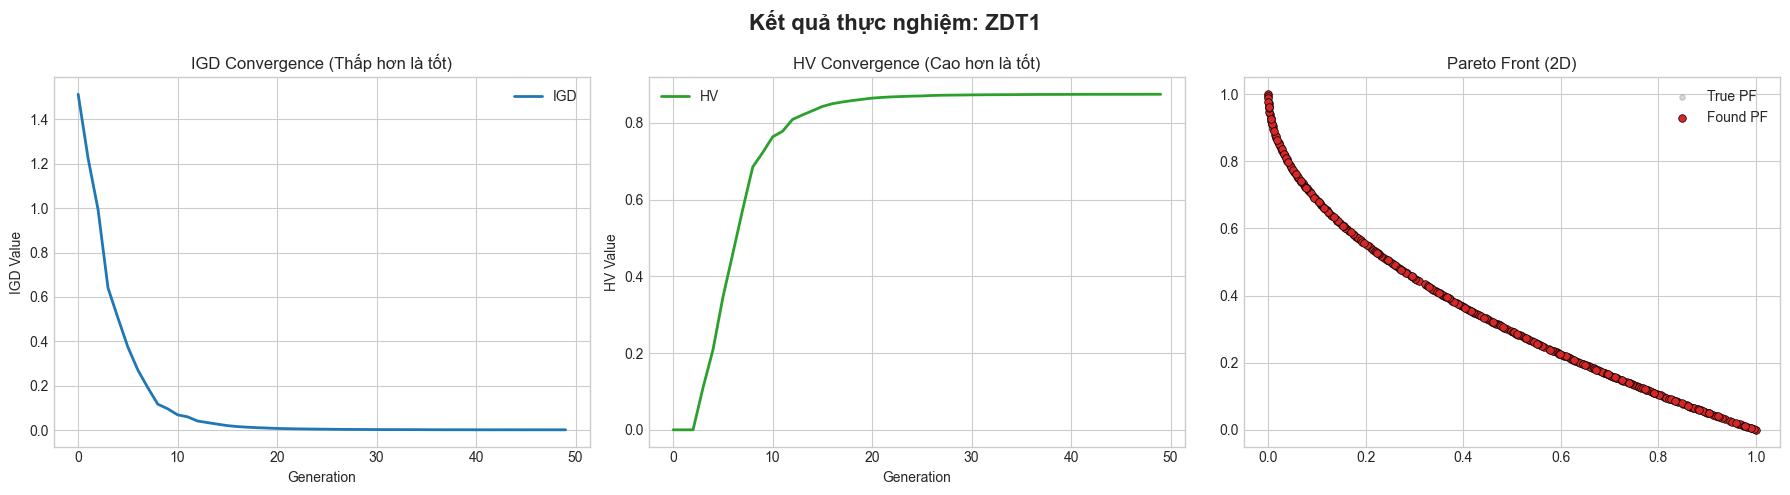

..................................................BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): ZDT2
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=50
Thời gian chạy: 2.2000 giây
  >> IGD Final: 0.190365
  >> HV  Final: 0.319151


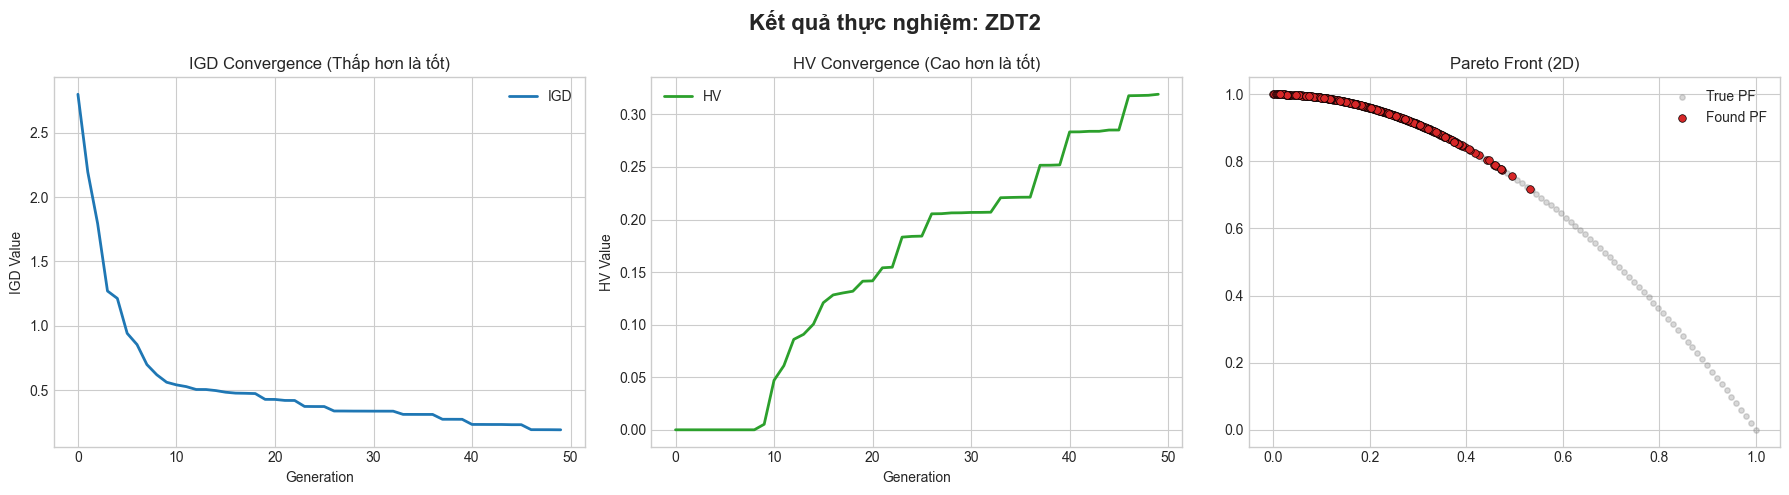

..................................................BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): ZDT3
• Cấu hình: Obj=2 | Var=30 | Pop=300 | Gen=50
Thời gian chạy: 1.9701 giây
  >> IGD Final: 0.004325
  >> HV  Final: 1.023404


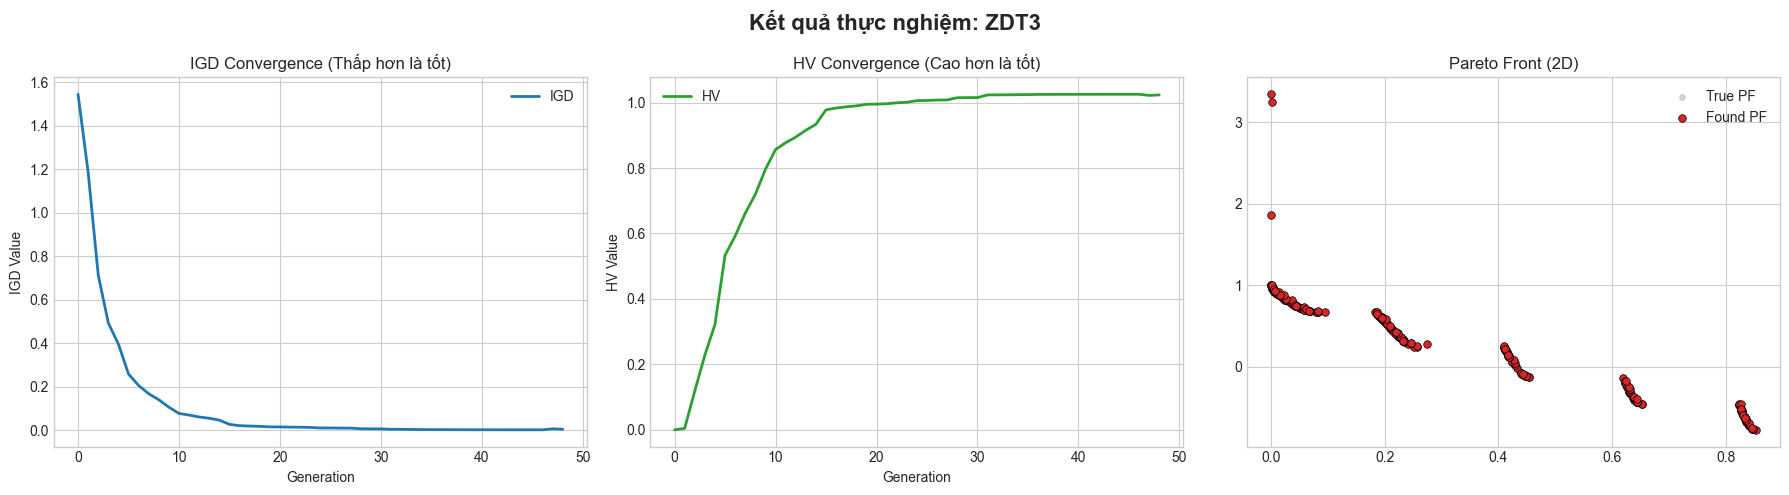

..................................................BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): ZDT4
• Cấu hình: Obj=2 | Var=10 | Pop=300 | Gen=50
Thời gian chạy: 2.4057 giây
  >> IGD Final: 8.457355
  >> HV  Final: 0.000000


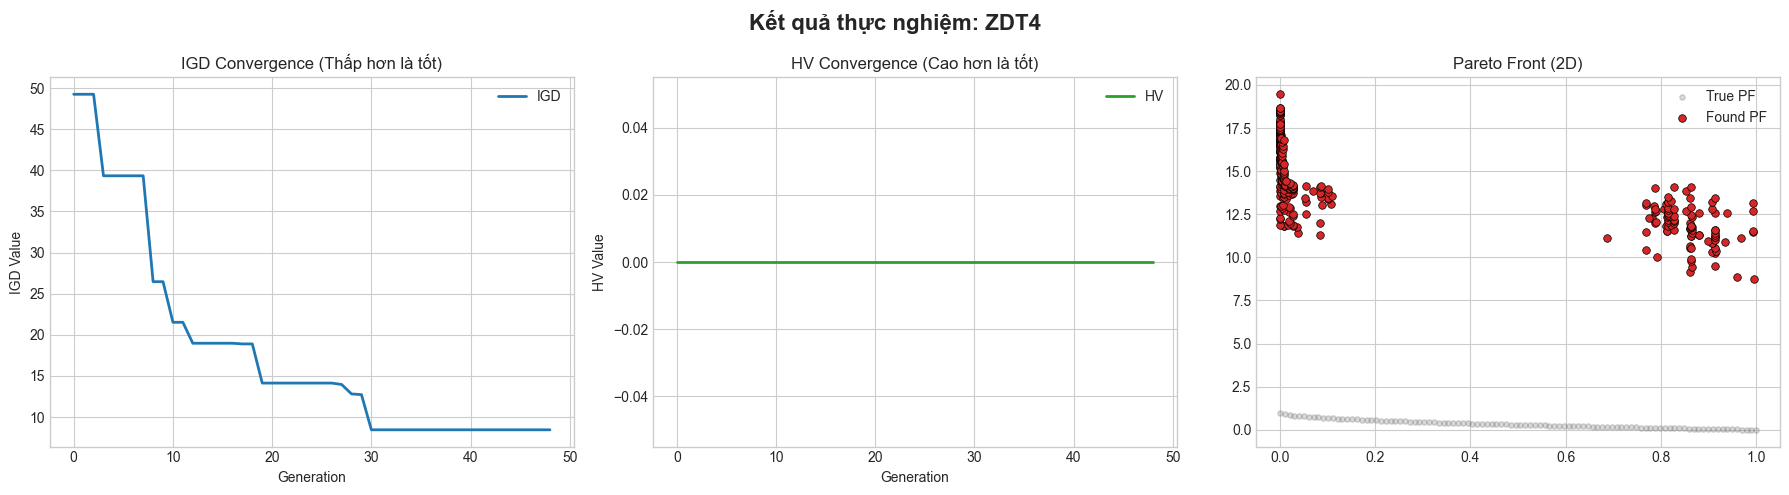

..................................................BẮT ĐẦU CHẠY (Lần cuối để vẽ hình): ZDT6
• Cấu hình: Obj=2 | Var=10 | Pop=300 | Gen=50
Thời gian chạy: 2.6182 giây
  >> IGD Final: 0.020603
  >> HV  Final: 0.404817


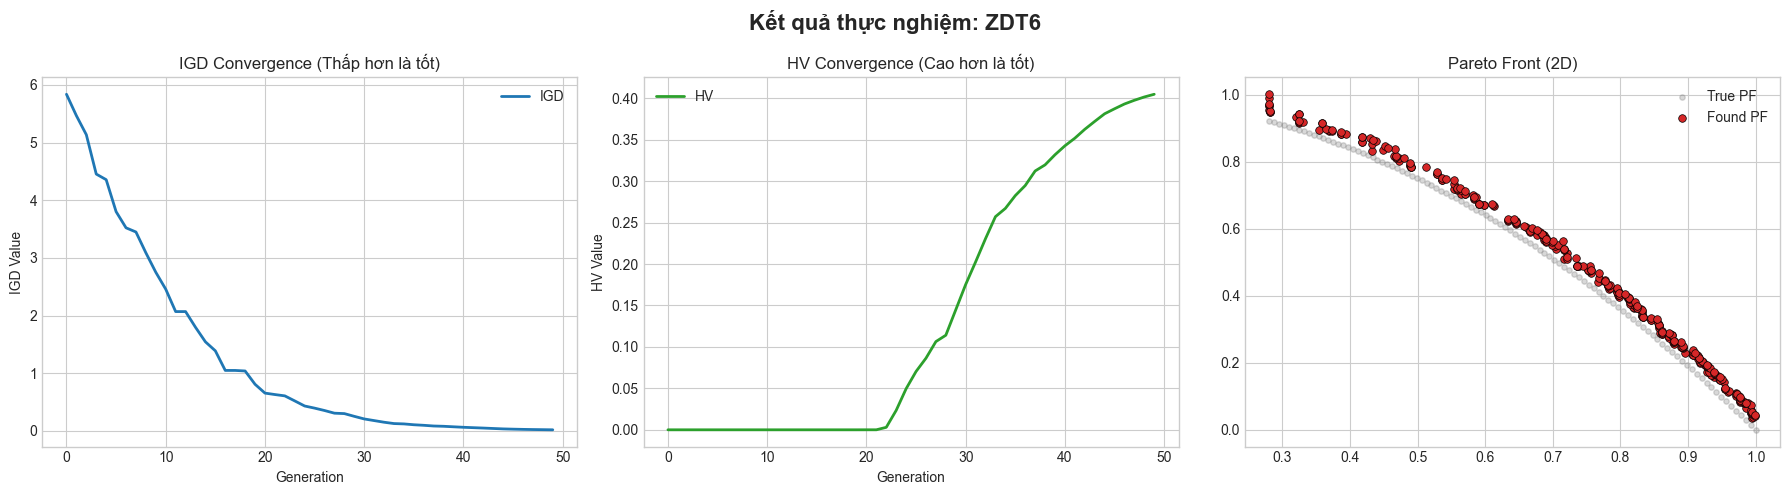

.

               KẾT QUẢ TỔNG HỢP (TRUNG BÌNH ± ĐỘ LỆCH CHUẨN - 50 LẦN CHẠY)                
╒═══════════╤══════════════════╤═════════╤═════════╤════════════════════╤════════════════════╤════════════╕
│ Problem   │ Algorithm        │   n_Var │   n_Obj │ IGD (Mean ± Std)   │ HV (Mean ± Std)    │   Time (s) │
╞═══════════╪══════════════════╪═════════╪═════════╪════════════════════╪════════════════════╪════════════╡
│ ZDT1      │ Improved NSGA-II │      30 │       2 │ 0.00176 (±0.00061) │ 0.87435 (±0.00086) │    3.88471 │
├───────────┼──────────────────┼─────────┼─────────┼────────────────────┼────────────────────┼────────────┤
│ ZDT2      │ Improved NSGA-II │      30 │       2 │ 0.07151 (±0.11010) │ 0.46119 (±0.11751) │    3.63356 │
├───────────┼──────────────────┼─────────┼─────────┼────────────────────┼────────────────────┼────────────┤
│ ZDT3      │ Improved NSGA-II │      30 │       2 │ 0.00280 (±0.00119) │ 1.02488 (±0.00121) │    2.2176  │
├───────────┼──────────────────┼─────────┼

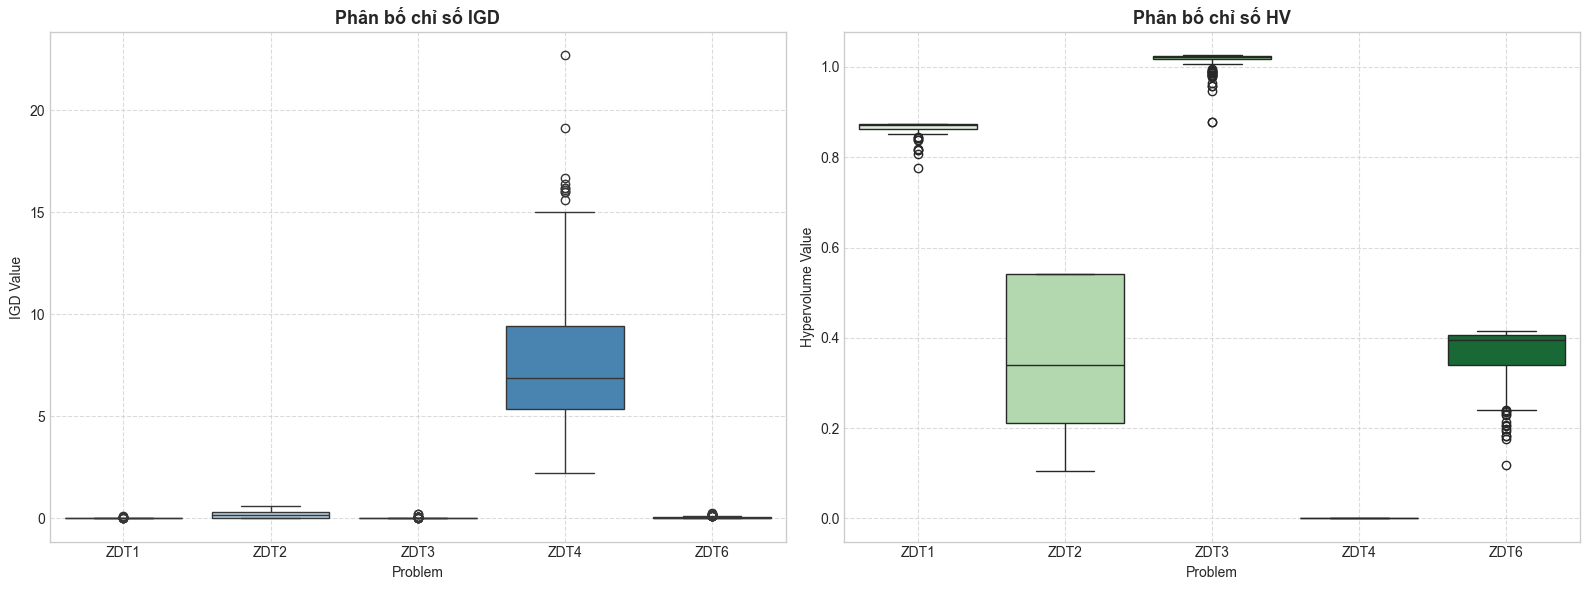

In [11]:
POP_SIZE = 300
N_GEN = 50
N_RUNS = 50

problems_list = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']
# problems_list = ['dtlz1', 'dtlz2', 'dtlz3', 'dtlz4', 'dtlz5', 'dtlz6', 'dtlz7']
k_mapping_dtlz = {"dtlz1": 5, "dtlz2": 10, "dtlz3": 10, "dtlz4": 10, "dtlz5": 10, "dtlz6": 10, "dtlz7": 20}

final_results_summary = []
for p_name in problems_list:
    if 'dtlz' in p_name:
        n_obj = 3
        k = k_mapping_dtlz.get(p_name, 10)
        n_var = n_obj + k - 1
    elif 'zdt' in p_name:
        n_obj = 2
        if any(x in p_name for x in ['zdt1', 'zdt2', 'zdt3']): n_var = 30
        elif any(x in p_name for x in ['zdt4', 'zdt6']): n_var = 10
        else: n_var = 30
    temp_runs_data = []

    for i in range(N_RUNS):
        is_last_run = (i == N_RUNS - 1)
        current_seed = i 

        res = run_experiment(
            p_name,
            n_gen=N_GEN,
            default_pop_size=POP_SIZE,
            seed=current_seed,
            n_var=n_var,
            n_obj=n_obj,
            do_plot=is_last_run
        )
        temp_runs_data.append(res)
        print(f".", end="")
    df_temp = pd.DataFrame(temp_runs_data)

    mean_vals = df_temp.mean(numeric_only=True)
    std_vals = df_temp.std(numeric_only=True)
 
    df_temp['Problem'] = p_name.upper()
    if 'all_raw_data' not in locals(): all_raw_data = pd.DataFrame()
    all_raw_data = pd.concat([all_raw_data, df_temp], ignore_index=True)

    summary_row = {
        'Problem': p_name.upper(),
        'Algorithm': "Improved NSGA-II",
        'n_Var': temp_runs_data[0]['n_Var'],
        'n_Obj': temp_runs_data[0]['n_Obj'],
        'IGD (Mean ± Std)': f"{mean_vals['IGD']:.5f} (±{std_vals['IGD']:.5f})", 
        'HV (Mean ± Std)': f"{mean_vals['HV']:.5f} (±{std_vals['HV']:.5f})",
        'Time (s)': mean_vals['Time (s)']
    }
    final_results_summary.append(summary_row)

df_summary = pd.DataFrame(final_results_summary)

print("\n")
print(f"KẾT QUẢ TỔNG HỢP (TRUNG BÌNH ± ĐỘ LỆCH CHUẨN - {N_RUNS} LẦN CHẠY)".center(90))
print(tabulate(df_summary, headers='keys', tablefmt='fancy_grid', showindex=False))

if not all_raw_data.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(
        data=all_raw_data, 
        x='Problem', 
        y='IGD', 
        hue='Problem',  
        legend=False,   
        ax=axes[0], 
        palette="Blues"
    )
    axes[0].set_title('Phân bố chỉ số IGD', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('IGD Value')
    axes[0].grid(True, linestyle='--', alpha=0.7)
    sns.boxplot(
        data=all_raw_data, 
        x='Problem', 
        y='HV', 
        hue='Problem',  
        legend=False,   
        ax=axes[1], 
        palette="Greens"
    )
    axes[1].set_title('Phân bố chỉ số HV', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Hypervolume Value')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu để vẽ biểu đồ.")